**1. Нужно взять три POS теггера для русского языка (я выбрала *spacy, stanza и udpipe*) и «прогнать» текст через каждый из них.**

**2. Оценить accuracy для каждого теггера, приведя всё к единому стандарту и сравнивая с эталоном ручной разметки.**

# Spacy

In [1]:
import spacy

nlp = spacy.load('ru_core_news_sm')

use_spacy — функция, которая получает на вход файл, берёт только предложения. Используя частеречную разметку spacy записывает результат в файл.

In [2]:
def use_spacy(file):
    
    s = 0
    with open('spacy.txt', 'a', encoding = 'utf-8') as f_output:
        with open(file, 'r', encoding = 'utf-8') as f_input:
            for line in f_input.readlines():
                if 'text' in line:
                    f_output.write(line)
                    sentence = line[9:-1]
                    spacy_tags = nlp(sentence)
                    for word in spacy_tags:
                        f_output.write(word.text+'\t'+word.pos_+'\n')
                elif 'sent_id' in line:
                    if s != 0:
                        f_output.write('\n'+line)
                    else:
                        f_output.write(line)
                        s = 1

In [3]:
use_spacy('corpus.conllu')

Теперь надо сравнить теги. Я посмотрела glossary и увидела, что в spacy используется Universal Pos tags. А это значит, что мне не надо ничего сводить к одному стандарту. 

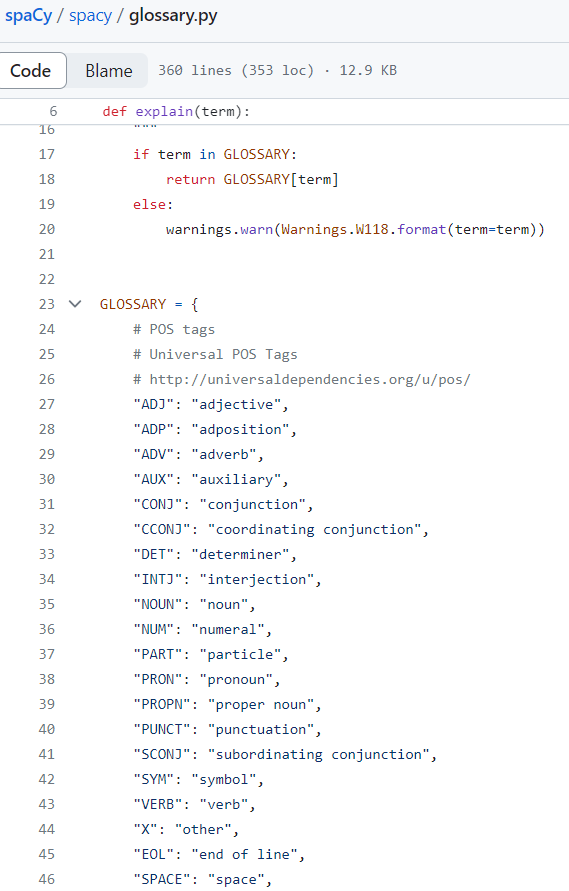

Нужно посчитать accuracy. Основная проблема заключается в том, что некоторые слова надо было объединять, например, *как известно*. Получается, что в моём стандарте токенов иногда будет меньше (а иногда больше). Как я решила поступить:

Я буду идти по строчкам моего файла. Если вдруг в строчке будет количество символов отличаться в большую сторону от того, что в строчке от spacy, то тогда я посмотрю на количество слов и заменю нужное количество слов одним ответом "NO" в списке с ответами spacy (так как теггер ошибся в таком случае неправильно выделив ту или иную часть речи). (Я надеюсь, что вместе с кодом это будет понятно). Если же в меньшую сторону, то тогда я также поставлю "NO" в список с ответами, столько раз, сколько лишных слов объединил spacy.

Дальше с дефисом и точками при сокращении отдельная тема. Мне кажется, что словами это очень трудно объяснить, поэтому в коде есть комментарии (они даже немного визуально разделяют на части).

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
def accuracy_check(f_corpus, f_spacy):
    results = []
    origin = []
    
    n = 0 #Счётчик строк для spacy
    flag = 0 #Это флаг если меньше
    with open(f_spacy, 'r', encoding = 'utf-8') as spacy_f:
        spacy_lines = spacy_f.readlines()

        with open(f_corpus, 'r', encoding = 'utf-8') as corpus_f:
            for line in corpus_f.readlines():
                
                if line[0]!='#' and line[0]!='\n':
                    line = line.split('\t')
                    line_sp = spacy_lines[n].strip('\n')
                    line_sp = line_sp.split('\t')
                    word_line = line[1].split()
                    word_sp = line_sp[0].split()
                    
                    if ('«' in line[1]) and (len(word_sp[0])>1): #Если не отделились кавычки, то тогда я ничего не добавляю (не считаю это за серьёзную ошибку)
                            continue
                    
                    elif ('»' in line[1]) and ('»' not in word_sp[0]):
                            continue
  
                    elif len(word_line) > len(word_sp): #Если у меня больше слов в строке (максимум объединяла два слова)
                        origin.append(line[3])
                        results.append('NO')
                        n+=2
                    
                    elif len(word_line) < len(word_sp): #Если у меня меньше слов в строке
                        if flag == 0:
                            flag = 1
                            results.append('NO')
                            origin.append(line[3])
                        else:
                            results.append('NO')
                            origin.append(line[3])
                            n+=1
                        
                    else: #Если одинаково
                        if '-' in line[1] and len(line[1].split('-'))>1: #Если разделил слово по дефису
                            word_cor = line[1].split('-')
                            word_sp = line_sp[0].split('-')
                            if len(word_cor) > len(word_sp):
                                origin.append(line[3])
                                results.append('NO') #Так как теггер изначально сделал ощибку, разделив слово таким образом
                                if len(word_cor) == 2:
                                    n+=3
                                else:
                                    while word_cor[-1] not in spacy_lines[n]: #Пока не найдём конец
                                        n+=1
                                    line_sp_new = spacy_lines[n].strip('\n')
                                    line_sp_new = line_sp_new.split('\t')
                                    tokens = line_sp_new[0].split('-')
                                    if word_cor[-1] != tokens[-1]: #Если вдруг теггер разделил не на равные части длинное слово (1 и 3 части, например)
                                        n-=1
                                    else:
                                        n+=1
                            elif len(word_cor) < len(word_sp): #Если вдруг надо было делить (такого случая у меня нет, но пусть будет для универсальности)
                                origin.append(line[3])
                                results.append('NO')
                                if word_cor[-1] == tokens[-1]:
                                    n+=1
                            else: #Если совпало с эталоном
                                n+=1
                                origin.append(line[3])
                                results.append(line_sp[1])
                        
                        elif ('.' in line[1] and len(line[1])>1) and ('.' not in spacy_lines[n]): #Если у меня есть точка в сокращении, а у теггера нет (он её отдельно выделил)
                            origin.append(line[3])
                            results.append(line_sp[1])
                            n+=2
                                    
                        else:
                            origin.append(line[3])
                            results.append(line_sp[1])
                            n+=1
                                   
                else:
                    n+=1
    print(f'result: {accuracy_score(results, origin)}')

In [6]:
accuracy_check('corpus.conllu', 'spacy.txt')

result: 0.8848920863309353


**Комментарий**: 

Изначально такое длинное полотно было для каждого теггера, но потом я нашла в себе силы свести всё к одной общей функции для всех трёх теггеров. Именно поэтому в названии переменных присутствует spacy, хотя это вообще для всех. 

Я знаю, что у меня много ветвлений получилось. Вполне возможно, что пройтись можно было бы по строкам аккуратнее и как-то лучше и изящнее сделать это. А ещё у меня есть сомнение, что на каком-то другом наборе текстоd оно будет нормально работать. С другой стороны, об универсальности в задании речь не шла.

А ещё алгоритм может показаться страным, но это из-за того, что я делала всё ночью и могла забыть об очевидных вещах. Прости, что много текста и много кода. Я старалась всё пояснять.

# Stanza

In [7]:
import stanza

nlp_2 = stanza.Pipeline(lang='ru', processors='tokenize,pos')

2023-10-04 21:39:14 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-10-04 21:39:15 INFO: Loading these models for language: ru (Russian):
| Processor | Package          |
--------------------------------
| tokenize  | syntagrus        |
| pos       | syntagrus_charlm |

2023-10-04 21:39:15 INFO: Using device: cpu
2023-10-04 21:39:15 INFO: Loading: tokenize
2023-10-04 21:39:15 INFO: Loading: pos
2023-10-04 21:39:16 INFO: Done loading processors!


use_stanza делает абсолютно идентичную вещm, что и spacy (только тут к тегам чуть дольще добираться).

In [8]:
def use_stanza(file):
    
    s = 0
    with open('stanza.txt', 'a', encoding = 'utf-8') as f_output:
        with open(file, 'r', encoding = 'utf-8') as f_input:
            for line in f_input.readlines():
                if 'text' in line:
                    f_output.write(line)
                    sentence = line[9:-1]
                    stanza_sentences = nlp_2(sentence)
                    for sent in stanza_sentences.sentences:
                        for word in sent.words:
                            f_output.write(word.text+'\t'+word.upos+'\n')
                elif 'sent_id' in line:
                    if s != 0:
                        f_output.write('\n'+line)
                    else:
                        f_output.write(line)
                        s = 1

In [9]:
use_stanza('corpus.conllu')

Теперь надо сравнить теги. Тут тоже используется Universal Pos tags.

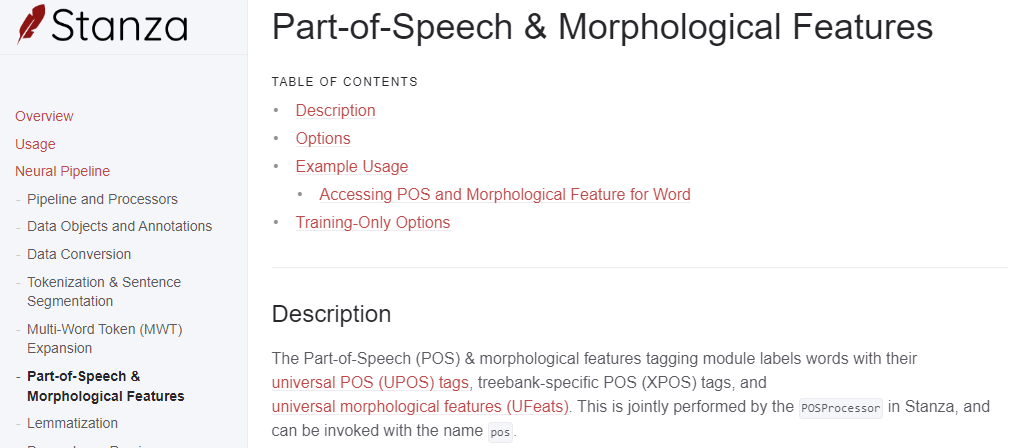

А ещё, так как я записала в таком же формате в файл, то я могу воспользоваться прошлой функцией для spacy.

In [10]:
accuracy_check('corpus.conllu', 'stanza.txt')

result: 0.920863309352518


# Udpipe

In [11]:
import ufal.udpipe as udp
from model import Model

In [12]:
model = Model('russian-syntagrus-ud-2.4-190531.udpipe')

use_udpipe много чего записывает (я пыталась выделить отдельно какие-то части, но без успеха). Получается всё в формате conllu.

In [13]:
def use_udpipe(model, file):

    s = 0
    with open('udpipe.txt', 'a', encoding = 'utf-8') as f_output:
        with open(file, 'r', encoding = 'utf-8') as f_input:
            for line in f_input.readlines():
                if 'text' in line:
                    sentence = line[9:-1]
                    sentences = model.tokenize(sentence)
                    for s in sentences:
                        model.tag(s)
                        model.parse(s)
                    conllu_text = model.write(sentences, "conllu")
                    f_output.write(conllu_text)

In [14]:
use_udpipe(model, 'corpus.conllu')

Тут тоже Universal POS tags, так как модель у нас syntagrus.

Меня бесят лишние строчки с #, поэтому в следующей ячейке я их удаляю. А ещё я решила вновь не писать заново функцию accuracy, поэтому нужно привести данный к тому виду, что были в прошлых файлах.

In [15]:
n = 1
with open('udpipe_2.0.txt', 'a', encoding = 'utf-8') as f_output:
    with open('udpipe.txt', 'r', encoding = 'utf-8') as f_input:
            for line in f_input.readlines():
                if ('# newdoc' not in line) and ('# newpar' not in line):
                    if 'sent_id' in line:
                        f_output.write(f'# sent_id = {n} \n')
                        n+=1
                    elif '\t' in line:
                        
                        line = line.split('\t')

                        f_output.write(line[1]+'\t'+line[3]+'\n')
                    else:
                        f_output.write(line)

In [16]:
accuracy_check('corpus.conllu', 'udpipe_2.0.txt')

result: 0.8786764705882353


Ура! Эти пункты закончились. Я думала, что результаты будут хуже, но в целом неплохо. Победил теггер Stanza.

**3. Какие 3 шаблона будем выделять в n-граммы.**

1) ADV + ADJ. Так уж случается, что наречие может поменять свою тональность из-за прилагательного, которое стоит следом. Например, *ужасно красивый спектакль*. *Ужасный* имеет отрицательную тональность, но в сочетании с прилагательным *красивый*, получается, что спектакль на самом деле был очень красивым до ужаса (то есть очень). С положительной тональностью аналогично: *невероятно* обычно относится к чему-то более положительному (*это невероятно*), но если посмотреть на сочетание *невероятно глупый*, то это однозначно отрицательная тональность.

2) "Не" + VERB. Элементарная вещь, конечно, однако она позволяет нам уточнить действие. Например, *не оторваться* (очень понравилось, положительная оценка) и *не понравилось* (отрицательная оценка). Если мы отдельно будем брать каждое слово, то *не* вообще не надо брать в расчёт, так как оно есть как и для положительной оценки, так и для отрицательной. Тогда остаются *понравилось*, которое имеет положительную оценку и *оторваться*, которое без контекста не имеет явной положительной или отрицательной тональности.

3) ADV + VERB (и наоборот, так как в этом случае порядок слов чуть менее закреплён). По аналогии с первым шаблоном: *ужасно понравилось* (положительная оценка), *невероятно разочаровало* (отрицательная оценка). Наречие меняет свою тональность в зависимости от последующего глагола. 

**4. Создание функции.**

In [17]:
import nltk
from nltk.tokenize import sent_tokenize

from pymorphy2 import MorphAnalyzer

In [18]:
morph = MorphAnalyzer()

Так как у меня 3 условия, то я решила не запихивать их в один if с помощью or. Это тяжело читать и выглядит не очень красиво. Функция получает на вход лемматизированный текст (так как далее мы будем запускать эту функцию вместе с подсчётом слов), делит на предложения, в каждом предложении теггер stanza всё разбирает, а потом находит нужные шаблоны биграмм.

In [19]:
def chunker(text):
    
    words_tags_list = []
    for sentence in sent_tokenize(text):
        stanza_sentences = nlp_2(sentence)
        for sent in stanza_sentences.sentences:
            for word in sent.words:
                    new_word = [word.text, word.upos]
                    words_tags_list.append(new_word)
    
    bigrams_final = []
    for i in range(len(words_tags_list)-1):
        if words_tags_list[i][1] == 'ADV' and words_tags_list[i+1][1] == 'ADJ':
            bigram = words_tags_list[i][0]+' '+words_tags_list[i+1][0]
            bigrams_final.append(bigram)
        
        elif words_tags_list[i][0].lower() == 'не' and words_tags_list[i+1][1] == 'VERB':
            bigram = words_tags_list[i][0]+' '+words_tags_list[i+1][0]
            bigrams_final.append(bigram)
            
        elif words_tags_list[i][1] == 'ADV' and words_tags_list[i+1][1] == 'VERB':
            bigram = words_tags_list[i][0]+' '+words_tags_list[i+1][0]
            bigrams_final.append(bigram)
            
        elif words_tags_list[i][1] == 'VERB' and words_tags_list[i+1][1] == 'ADV':
            bigram = words_tags_list[i][0]+' '+words_tags_list[i+1][0]
            bigrams_final.append(bigram)
            
    return bigrams_final

**5. Берём предыдущую домашку и добавляем туда эту функцию.**

Воспользуемся уже готовым файлом, который остался с прошлой домашки (я его не забыла добавить на гитхаб!)

In [20]:
import pandas as pd

from tqdm.auto import tqdm

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import Counter

from sklearn.metrics import accuracy_score

In [21]:
sw = stopwords.words('russian')

In [22]:
df_review = pd.read_csv('df_review.csv')

Спасибо за совет по обработке!

In [23]:
tqdm.pandas()

In [24]:
def lemmatize(text):
    text = [w.lower() for w in word_tokenize(text) if w.isalpha()]
    return " ".join([morph.parse(t)[0].normal_form for t in text])

In [25]:
df_review["lemmatized"] = df_review.review.progress_apply(lemmatize)

  0%|          | 0/222 [00:00<?, ?it/s]

In [26]:
df_review

,grade,review,lemmatized
0,positive,Замечательный мюзикл. Прекрасно провели время....,замечательный мюзикл прекрасно провести время ...
1,positive,пойду снова в третий раз !!!!!,пойти снова в третий раз
2,positive,Как будто попал 1990 лет назад или 33 год наше...,как будто попасть год назад или год наш эра во...
3,positive,Спектакль очень понравился! Замечательная музы...,спектакль очень понравиться замечательный музы...
4,positive,Я просто полностью погрузился в атмосферу спек...,я просто полностью погрузиться в атмосфера спе...
...,...,...,...
217,negative,Ушли после первого акта. Юмор дешёвого стендап...,уйти после первый акт юмор дешёвый стендап всё...
218,negative,"Не смотря на самоотверженную игру актёров, спе...",не смотреть на самоотверженный игра актёр спек...
219,negative,"Был на спектакле, запомнились яркие костюмы, л...",быть на спектакль запомниться яркий костюм чел...
220,negative,"Неприятное действо, все время не покидала мысл...",неприятный действо всё время не покидать мысль...


Делим выборку

In [27]:
df_pos = df_review[(df_review['grade'] == 'positive')]
df_pos_test = df_pos.sample(n=10)

df_neg = df_review[(df_review['grade'] == 'negative')]
df_neg_test = df_neg.sample(n=10) 

df_test = pd.concat([df_neg_test, df_pos_test])

index = df_test.index.tolist ()
df_review.drop(labels = index, axis = 0, inplace = True)

Записываем в самом начале просто по отдельности слова, а потом ищем биграммы, но записываем отдельно (занимает достаточно много времени, так как chunker не очень эффективный получился)

In [28]:
words_bigramm_negative_reviews = []
words_bigramm_positive_reviews = []

for i, row in tqdm(df_review.iterrows()):
    if row['grade'] == 'negative':
        for word in row['lemmatized'].split():
            if word not in sw:
                words_bigramm_negative_reviews.append(word)
        is_bigram = chunker(row['lemmatized'])
        for element in is_bigram:
            words_bigramm_negative_reviews.append(element)
    else:
        for word in row['lemmatized'].split():
            if word not in sw:
                words_bigramm_positive_reviews.append(word)
        is_bigram = chunker(row['lemmatized'])
        for element in is_bigram:
            words_bigramm_positive_reviews.append(element)

0it [00:00, ?it/s]

In [29]:
both_dicts = {}

In [30]:
freqlist = Counter()
for word in words_bigramm_negative_reviews:
    freqlist[word] += 1
dict_negative_reviews = dict(freqlist)
both_dicts['negative'] = dict_negative_reviews

freqlist = Counter()
for word in words_bigramm_positive_reviews:
    freqlist[word] += 1
dict_positive_reviews = dict(freqlist)
both_dicts['positive'] = dict_positive_reviews

In [31]:
most_freq_neg = []

for element in both_dicts['negative']:
    if dict_negative_reviews[element] > 2:
        most_freq_neg.append(element)

most_freq_pos = []
for element in both_dicts['positive']:
    if dict_positive_reviews[element] > 2:
        most_freq_pos.append(element)

In [32]:
neg = set(most_freq_neg)
pos = set(most_freq_pos)
neg_pos = set.intersection(neg, pos)

In [33]:
neg.symmetric_difference_update(neg_pos)
pos.symmetric_difference_update(neg_pos)

Эти функции определяют тональность. Если мы смотрим на биграммы, то мы также будем делить сам текст на них. Иначе просто проходимся по каждому слову.

In [34]:
def pos_or_neg_with_bigramm(set_pos, set_neg, review_input):

    positive = 0
    negative = 0
    
    review = word_tokenize(review_input)
    for i in range(len(review)-1):
        bigram_check = review[i]+' '+review[i+1]
        
        if review[i] in set_pos:
            positive+= 1
        elif review[i] in set_neg:
            negative+= 1
        elif bigram_check in set_pos:
            positive+= 1 
        elif bigram_check in set_neg:
            negative+= 1
    #в цикле мы не проверяем последнее слово, поэтому отдельно его посмотрим
    if review[len(review)-1] in set_pos:
        positive+= 1
    elif review[len(review)-1] in set_neg:
        negative+= 1
    
    if positive > negative:
        return 'positive'
    else:
        return 'negative'

In [35]:
def pos_or_neg(set_pos, set_neg, review_input):

    positive = 0
    negative = 0
    
    review = word_tokenize(review_input)
    for word in review:        
        if word in set_pos:
            positive+= 1
        elif word in set_neg:
            negative+= 1
    
    if positive > negative:
        return 'positive'
    else:
        return 'negative'

**6. Считаем новое accuracy и сравниваем с предыдущим.**

In [36]:
def test_tone_detect(set_pos, set_neg, df_test):
    results_bigramm = []
    results = []
    origin = []
    
    for i, row in df_test.iterrows():
        predicted_tone_1 = pos_or_neg_with_bigramm(set_pos, set_neg, row['lemmatized'])
        results_bigramm.append(predicted_tone_1)
        predicted_tone_2 = pos_or_neg(set_pos, set_neg, row['lemmatized'])
        results.append(predicted_tone_2)

        origin.append(row['grade'])

    print(f'result with bigramm: {accuracy_score(results_bigramm, origin)}')
    print(f'result without: {accuracy_score(results, origin)}')

In [37]:
test_tone_detect(pos, neg, df_test)

result with bigramm: 0.65
result without: 0.6


Результат получился 0.7 с биграммами и 0.65 без, что я по этому поводу думаю:

1) Из-за второго шаблона есть большой перекос биграмм с отрицательной оценкой. А ещё я поняла, что *не+глагол* может в целом нести и положительную оценку *не хотелось уходить*. Получается, что шаблон выбран не очень удачно, но других идей у меня не было.

2) В прошлой домашке была точность 0.75. Тут получилось ниже. Кажется, что это зависит от тестовой выборки, так как могут быть отзывы с результатом positive 1, negative 1. Нельзя сказать, что у нас средний отзыв, поэтому мне пришлось относить подобное к отрицательной тональности. Видимо, в прошлой домашке попались просто более удачные отзывы. А ещё мне повезло при итоговом тесте, так как до этого несколько раз мне попадалась выборка без словосочетаний и получались одинаковые результаты.

3) Последняя проблема заключается в том, что множество neg вышло намного больше. Надо было бы лучше поработать с частотностью именно этих слов и биграмм (хотя алгоритм слишком наивный, чтобы настолько сильно заморачиваться).

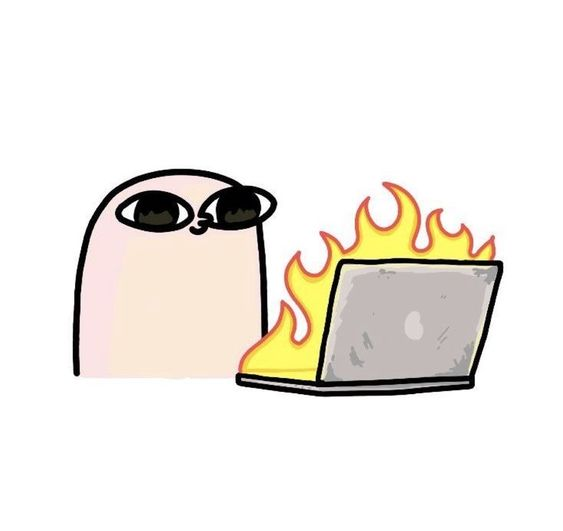